# Modelo MLP para clasificar imagenes de CIFAR-100

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%load_ext tensorboard

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import models
from tensorflow.keras import layers, models, regularizers, constraints

Cargamos los datos

In [3]:
import pickle
with open("dataset/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)
with open("dataset/coarse_label_names.pck", "rb") as f:
    labels_coarse = pickle.load(f)


In [4]:
x_train = np.load("dataset/x_train.npy") #/255.
x_test = np.load("dataset/x_test.npy") #/255.
#y_train_coarse = np.load("dataset/y_train_coarse.npy")
y_train_fine = np.load("dataset/y_train_fine.npy")

In [5]:
y_train_fine.shape

(50000,)

In [6]:
x_train.shape

(50000, 32, 32, 3)

In [7]:
x_train,x_val, y_train, y_val = train_test_split(x_train, y_train_fine, test_size=0.1, stratify=y_train_fine)

In [8]:
x_val = x_val/np.float16(255.)

In [9]:
y_val.shape

(5000,)

In [10]:
x_val.shape

(5000, 32, 32, 3)

#### Data augmentation

In [11]:
x_train_horizontal_flip= x_train[:,:,::-1,:]
x_train_vertical_flip = x_train[:,::-1,:,:]
x_train_vh_flip =x_train[:, ::-1, ::-1, :]

x_train_dup = np.concatenate([x_train,x_train_horizontal_flip,x_train_vertical_flip,x_train_vh_flip],axis=0)
y_train_dup = np.concatenate([y_train, y_train,y_train, y_train], axis=0)

x_train_bis = x_train_dup.copy()
x_train_bis_bis = x_train_dup.copy()


x_train_bis[:,:,1:,:] =x_train_dup[:,:,:-1,:]
x_train_bis_bis[:,:,:-1,:] =x_train_dup[:,:,1:,:]

x_train_dup = np.concatenate([x_train_dup, x_train_bis, x_train_bis_bis],axis=0)
y_train_dup = np.concatenate([y_train_dup, y_train_dup, y_train_dup], axis=0)


In [12]:
print(f'Original dataset size: {len(x_train)}')
print(f'Augmented dataset size: {len(x_train_dup)}')

Original dataset size: 45000
Augmented dataset size: 540000


In [13]:
x_train_dup = x_train_dup/np.float16(255.)

In [14]:
x_train_dup.shape, y_train_dup.shape

((540000, 32, 32, 3), (540000,))

In [18]:
# Define model architecture with optimized fully connected layers
def create_model2(input_shape=(32, 32, 3), l2_lambda=0.001):
    # Input layer for images
    inputs = layers.Input(shape=input_shape)
    
    # Flattening layer
    x = layers.Flatten()(inputs)
    
    # Dense layers with Batch Normalization, Dropout, L2 regularization, and Max-Norm constraint
    for i in range(10,6,-1):
        x = layers.Dense(2**i,  
                     kernel_regularizer=regularizers.l2(l2_lambda),
                     )(x)
        
       
        x = layers.PReLU()(x)
      


   
    # Parallel output layers for fine and coarse predictions
    fine_output = layers.Dense(100, activation='softmax', name='fine_output')(x)   # Fine-grain prediction
    #coarse_output = layers.Dense(20, activation='softmax', name='coarse_output')(x) # Coarse-grain prediction
    
    # Create model
    model = models.Model(inputs=inputs, outputs=[fine_output])
    
    return model

In [19]:
# Instantiate the model
model = create_model2()

# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'fine_output': 'sparse_categorical_crossentropy', 
        #'coarse_output': 'sparse_categorical_crossentropy'
    },
    #metrics=['accuracy','accuracy']
    metrics={
        'fine_output': 'accuracy'  # Apply accuracy metric only to the fine output
    }
)

# Early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True,verbose= 1)

# rlrop = ReduceLROnPlateau(
#     monitor="val_fine_output_accuracy",  # Monitor fine output validation accuracy
#     factor=0.5,
#     patience=3,
#     verbose=1,
#     min_lr=1e-5
# )
tb = TensorBoard(log_dir="logs")
# Display the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_4 (PReLU)               │ (None, 1024)           │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_5 (PReLU)               │ (None, 512)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_6 (PReLU)               │ (None, 256)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_7 (PReLU)               │ (None, 128)            │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fine_output (Dense)             │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,850,596 (14.69 MB)

 Trainable params: 3,850,596 (14.69 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Fit the model
history5 = model.fit(
    x=x_train_dup,                          # Input data (images)
    y={'fine_output': y_train_dup,     # Fine labels target output
       #'coarse_output': y_train_dup[:,0]
       },
    validation_data=(x_val, {'fine_output': y_val}),
    epochs=10,                          # Set your number of epochs
    batch_size=500,                      # Batch size (tune as needed)
    #callbacks=[tb, early_stopping]     
    callbacks=[tb]   # TensorBoard and early stopping callbacks
)

Epoch 1/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 78s 69ms/step - accuracy: 0.0807 - loss: 4.5734 - val_accuracy: 0.1630 - val_loss: 3.6723
Epoch 2/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 66s 61ms/step - accuracy: 0.1738 - loss: 3.5901 - val_accuracy: 0.1872 - val_loss: 3.5464
Epoch 3/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 63s 58ms/step - accuracy: 0.2024 - loss: 3.4471 - val_accuracy: 0.1994 - val_loss: 3.4667
Epoch 4/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 63s 58ms/step - accuracy: 0.2224 - loss: 3.3561 - val_accuracy: 0.2064 - val_loss: 3.4667
Epoch 5/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 66s 61ms/step - accuracy: 0.2338 - loss: 3.2985 - val_accuracy: 0.2212 - val_loss: 3.4350
Epoch 6/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 63s 58ms/step - accuracy: 0.2482 - loss: 3.2304 - val_accuracy: 0.2340 - val_loss: 3.3943
Epoch 7/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 63s 58ms/step - accuracy: 0.2596 - loss: 3.1782 - val_accuracy: 0.2304 - val_loss: 3.4046
Epoch 8/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 63s 59ms/step - accuracy: 0.2681 -

In [21]:
# Save the model after 25 epochs
model.save("modelo_4densas_l2_0.001.keras")

In [22]:
from tensorflow.keras.models import load_model

In [23]:

# Load the model
trained_model = model

# Continue training for additional epochs
additional_epochs = 50

history_trained = trained_model.fit(
    x=x_train_dup,                          # Input data (images)
    y={'fine_output': y_train_dup,     # Fine labels target output
       #'coarse_output': y_train_dup[:,0]
       },
    validation_data=(x_val, {'fine_output': y_val}),
    epochs=additional_epochs,                          # Set your number of epochs
    batch_size=500,                      # Batch size (tune as needed)
    #callbacks=[tb, early_stopping]     
    callbacks=[tb]   # TensorBoard and early stopping callbacks
)


Epoch 1/50
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 75s 69ms/step - accuracy: 0.2979 - loss: 3.0147 - val_accuracy: 0.2324 - val_loss: 3.4809
Epoch 2/50
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 66s 61ms/step - accuracy: 0.3072 - loss: 2.9797 - val_accuracy: 0.2298 - val_loss: 3.5001
Epoch 3/50
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 58s 54ms/step - accuracy: 0.3151 - loss: 2.9466 - val_accuracy: 0.2390 - val_loss: 3.5241
Epoch 4/50
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 58s 54ms/step - accuracy: 0.3253 - loss: 2.9103 - val_accuracy: 0.2348 - val_loss: 3.5422
Epoch 5/50
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 57s 53ms/step - accuracy: 0.3328 - loss: 2.8873 - val_accuracy: 0.2314 - val_loss: 3.5649
Epoch 6/50
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 56s 52ms/step - accuracy: 0.3426 - loss: 2.8495 - val_accuracy: 0.2332 - val_loss: 3.6000
Epoch 7/50
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 57s 53ms/step - accuracy: 0.3497 - loss: 2.8208 - val_accuracy: 0.2358 - val_loss: 3.6547
Epoch 8/50
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 55s 51ms/step - accuracy: 0.3562 -

KeyboardInterrupt: 

### no funciono norm y drop

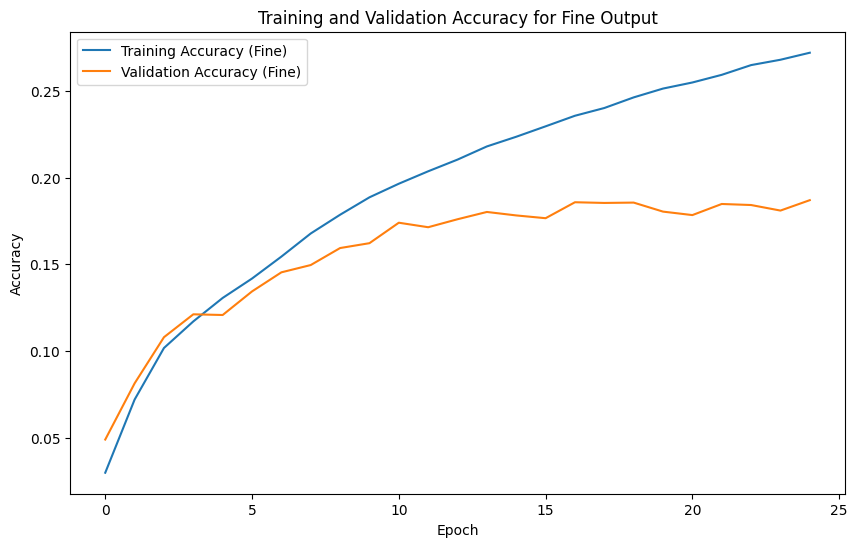

In [35]:
# Plot training and validation accuracy for fine output
plt.figure(figsize=(10, 6))
plt.plot(history5.history['accuracy'], label='Training Accuracy (Fine)')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy (Fine)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Fine Output')
plt.legend()
plt.show()